In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -lh /content/

total 8.0K
drwx------ 5 root root 4.0K Aug  5 11:09 drive
drwxr-xr-x 1 root root 4.0K Jul 29 13:36 sample_data


In [ ]:
import time
start = time.time()

!cp /content/drive/MyDrive/Df_Amz_all.csv /content/
end = time.time()

In [5]:
!ls -lh /content/

total 26M
-rw------- 1 root root  26M Aug  5 11:09 Df_Amz_all.csv
drwx------ 5 root root 4.0K Aug  5 11:09 drive
drwxr-xr-x 1 root root 4.0K Jul 29 13:36 sample_data


In [ ]:
import os

PROJECT_NAME = "lstm_outputs"  
GLOBAL_OUTPUT_DIR = f"/content/drive/MyDrive/Colab Notebooks/{PROJECT_NAME}"

subfolders = ["models", "plots", "predictions", "histories", "metrics", "csv"]

for sub in subfolders:
    os.makedirs(os.path.join(GLOBAL_OUTPUT_DIR, sub), exist_ok=True)

In [7]:
!pip install pandas numpy matplotlib seaborn hydroeval scikit-learn tensorflow

In [8]:
import os
import re
import json
from glob import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import hydroeval as he
from hydroeval import evaluator, kge, nse
from tqdm import tqdm


# Random seed setting (for consistency)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

#
df = pd.read_csv("/content/Df_Amz_all.csv", index_col=0)
df['date'] = pd.to_datetime(df['date'])

basin_ids = sorted(df["ID_CABra"].unique().tolist())
print(" All available basins:", basin_ids)


 All available basins: [11, 21, 22, 30, 31, 32, 35, 37, 42, 44, 46, 51, 52, 90, 91]


In [9]:
#Time Interval and Sliding Window Offset Settings
LOOKBACK = 90
DATE_TRAIN = ("1980-10-01", "1998-09-30")
DATE_VAL   = ("1998-10-01", "2004-09-30")
DATE_TEST  = ("2004-10-01", "2010-09-30")

shift = LOOKBACK - 1
DATE_VAL_SHIFTED = (
    (datetime.strptime(DATE_VAL[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_VAL[1]
)
DATE_TEST_SHIFTED = (
    (datetime.strptime(DATE_TEST[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_TEST[1]
)

ALL_DYNAMIC = ["prec_ref", "pet_pm"]
ALL_STATIC = [
    "clim_tmin","clim_tmax","clim_pmm","clim_petmm_day",
    "aridity_index","q_mean_mm","runoff_coef","baseflow_index",
    "cover_urban_%","cover_crops_%","res_number","hdisturb_index",
    "catch_area","elev_mean","catch_slope","catch_order"
]
ALL_FEATURES = ALL_DYNAMIC + ALL_STATIC
TARGET = "Qmm"
selected_features = ALL_FEATURES
static_features = [f for f in selected_features if f not in ALL_DYNAMIC]

FINAL_VARS = ["prec_ref", "pet_pm", "elev_mean", "q_mean_mm"]
print(f"\n Training final model with variables: {FINAL_VARS}")

basin_ids = [31]
df_filtered = df[df["ID_CABra"].isin(basin_ids)].copy()


shift = LOOKBACK - 1

DATE_VAL_SHIFTED = (
    (datetime.strptime(DATE_VAL[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_VAL[1]
)
DATE_TEST_SHIFTED = (
    (datetime.strptime(DATE_TEST[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_TEST[1]
)

train_data = df_filtered[(df_filtered["date"] >= DATE_TRAIN[0]) & (df_filtered["date"] <= DATE_TRAIN[1])].copy()
val_data = df_filtered[(df_filtered["date"] >= DATE_VAL_SHIFTED[0]) & (df_filtered["date"] <= DATE_VAL_SHIFTED[1])].copy()
test_data = df_filtered[(df_filtered["date"] >= DATE_TEST_SHIFTED[0]) & (df_filtered["date"] <= DATE_TEST_SHIFTED[1])].copy()


scaler = StandardScaler()
scaler.fit(train_data[static_features])

train_data.loc[:, static_features] = scaler.transform(train_data[static_features])
val_data.loc[:, static_features] = scaler.transform(val_data[static_features])
test_data.loc[:, static_features] = scaler.transform(test_data[static_features])

train_std = train_data.copy()
val_std   = val_data.copy()
test_std  = test_data.copy()


#Window Construction Function
def create_sequences(df, features, target, lookback):
    data = df[features].values
    labels = df[target].values
    n = len(df) - lookback + 1
    X = np.zeros((n, lookback, len(features)), dtype=np.float32)
    y = np.zeros(n, dtype=np.float32)
    for i in range(n):
        X[i] = data[i:i+lookback]
        y[i] = labels[i+lookback-1]
    return X, y

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

for basin in basin_ids:
    train_basin = train_std[train_std["ID_CABra"] == basin]
    val_basin   = val_std[val_std["ID_CABra"] == basin]
    test_basin  = test_std[test_std["ID_CABra"] == basin]

    X_tr, y_tr = create_sequences(train_basin, selected_features, TARGET, LOOKBACK)
    X_vl, y_vl = create_sequences(val_basin, selected_features, TARGET, LOOKBACK)
    X_te, y_te = create_sequences(test_basin, selected_features, TARGET, LOOKBACK)

    X_train_list.append(X_tr)
    y_train_list.append(y_tr)
    X_val_list.append(X_vl)
    y_val_list.append(y_vl)
    X_test_list.append(X_te)
    y_test_list.append(y_te)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

def check_data(data, name="Data"):
    if np.any(np.isnan(data)):
        raise ValueError(f"{name} contains NaN.")
    if np.any(np.isinf(data)):
        raise ValueError(f"{name} contains Inf.")
    print(f"{name} passed check. Shape: {data.shape}")

check_data(X_train, "X_train")
check_data(y_train, "y_train")
check_data(X_val, "X_val")
check_data(y_val, "y_val")


 Training final model with variables: ['prec_ref', 'pet_pm', 'elev_mean', 'q_mean_mm']
Shapes: (6485, 90, 18) (6485,) (2192, 90, 18) (2192,) (2191, 90, 18) (2191,)
X_train passed check. Shape: (6485, 90, 18)
y_train passed check. Shape: (6485,)
X_val passed check. Shape: (2192, 90, 18)
y_val passed check. Shape: (2192,)


In [10]:
# Prepare Data
train_final = train_std[FINAL_VARS + [TARGET]].copy()
val_final   = val_std[FINAL_VARS + [TARGET]].copy()
test_final  = test_std[FINAL_VARS + [TARGET]].copy()

X_train_final, y_train_final = create_sequences(train_final, FINAL_VARS, TARGET, LOOKBACK)
X_val_final,   y_val_final   = create_sequences(val_final, FINAL_VARS, TARGET, LOOKBACK)
X_test_final,  y_test_final  = create_sequences(test_final, FINAL_VARS, TARGET, LOOKBACK)

check_data(X_train_final, "X_train_final")
check_data(X_val_final, "X_val_final")
check_data(X_test_final, "X_test_final")

X_train_final passed check. Shape: (6485, 90, 4)
X_val_final passed check. Shape: (2192, 90, 4)
X_test_final passed check. Shape: (2191, 90, 4)


In [11]:
# Base Model Definition
#Model Definition
def make_model(lookback, num_feats, units, dp, lr):
    m = Sequential([
        Input(shape=(lookback, num_feats)),
        LSTM(units),
        Dropout(dp),
        Dense(1),
        Activation('relu')
    ])
    m.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=lr),
        metrics=['mean_squared_error']
    )
    return m

def concordance_correlation_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mean_t = y_true.mean()
    mean_p = y_pred.mean()
    cov = np.mean((y_true - mean_t) * (y_pred - mean_p))
    var_t = y_true.var()
    var_p = y_pred.var()
    return (2 * cov) / (var_t + var_p + (mean_t - mean_p)**2 + 1e-8)

def evaluate_model(model, X_val, y_val, name="Validation"):
    y_pred = model.predict(X_val).flatten()
    kge_val = float(np.atleast_1d(evaluator(kge, y_pred, y_val)).flatten()[0])
    nse_val = float(np.atleast_1d(evaluator(nse, y_pred, y_val)).flatten()[0])
    ccc_val = float(concordance_correlation_coefficient(y_val, y_pred))
    print(f"[{name}] KGE: {kge_val:.3f}, NSE: {nse_val:.3f}, CCC: {ccc_val:.3f}")
    return {
        "KGE": kge_val,
        "NSE": nse_val,
        "CCC": ccc_val,
        "y_pred": y_pred
    }

In [12]:
from google.colab import files
uploaded = files.upload()

Saving best_wts_FINAL4_u24_lr1e3_dp02_ID31_90d.h5 to best_wts_FINAL4_u24_lr1e3_dp02_ID31_90d.h5


In [13]:
units = 24
lr = 1e-3
dp = 0.2
best_ckpt = "/content/best_wts_FINAL4_u24_lr1e3_dp02_ID31_90d.h5"

In [14]:
# Build the model and load the weights
model = make_model(LOOKBACK, len(FINAL_VARS), units, dp, lr)
model.load_weights(best_ckpt)

In [15]:
X_ig, _ = create_sequences(val_std, FINAL_VARS, TARGET, LOOKBACK)

feature_names = FINAL_VARS

In [16]:
def interpolate_inputs(baseline, input, alpha):
    return baseline + alpha * (input - baseline)

def compute_gradients(model, inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
    return tape.gradient(predictions, inputs)

def integrated_gradients_single(model, baseline, input_tensor, m_steps=50):
    alphas = tf.linspace(0.0, 1.0, m_steps)
    integrated_grads = tf.zeros_like(input_tensor, dtype=tf.float32)
    for alpha in alphas:
        interpolated = interpolate_inputs(baseline, input_tensor, alpha)
        grads = compute_gradients(model, interpolated)
        integrated_grads += grads / m_steps
    return (input_tensor - baseline) * integrated_grads

def compute_integrated_gradients_all(model, X_input, feature_names,
                                     baseline_type="zero", m_steps=50,
                                     save_csv_path=None, plot=True):
    """
    Perform IG analysis on the entire sample set and output the variable importance matrix (lookback × features)
    """

    assert X_input.ndim == 3, "X_input must be 3D (samples, lookback, features)"
    assert len(feature_names) == X_input.shape[2], "Feature name count mismatch"

    print(" Running Integrated Gradients...")

    if baseline_type == "mean":
        baseline = tf.convert_to_tensor(np.mean(X_input, axis=0, keepdims=True), dtype=tf.float32)
    else:
        baseline = tf.zeros_like(X_input[0:1], dtype=tf.float32)

    all_importances = []
    for i in tqdm(range(len(X_input)), desc=" IG computing"):
        input_tensor = tf.convert_to_tensor(X_input[i:i+1], dtype=tf.float32)
        ig_tensor = integrated_gradients_single(model, baseline, input_tensor, m_steps)
        all_importances.append(ig_tensor.numpy().squeeze(0))

    all_importances = np.array(all_importances)
    mean_importance = np.mean(np.abs(all_importances), axis=0)
    print(" IG shape:", mean_importance.shape)

    df_importance = pd.DataFrame(mean_importance, columns=feature_names)

    if save_csv_path:
        os.makedirs(os.path.dirname(save_csv_path), exist_ok=True)
        df_importance.to_csv(save_csv_path, index=False)
        print(f" Saved IG matrix to: {save_csv_path}")

    if plot:
        # Bar chart (average importance)
        plt.figure(figsize=(10, 6))
        df_importance.mean().sort_values().plot(kind='barh', color='#4da6ff')
        plt.title("Mean IG Feature Importance", fontsize=13, weight='bold')
        plt.xlabel("Mean IG Score")
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        if save_csv_path:
            plt.savefig(save_csv_path.replace(".csv", "_barh.png"), dpi=300)
        plt.show()

        # heatmap（timestep × feature）
        plt.figure(figsize=(10, 6))
        plt.imshow(mean_importance.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='IG Importance')
        plt.yticks(np.arange(len(feature_names)), feature_names)
        plt.xlabel("Timestep")
        plt.title("IG Heatmap (time × feature)", fontsize=13, weight='bold')
        plt.tight_layout()
        if save_csv_path:
            plt.savefig(save_csv_path.replace(".csv", "_heatmap.png"), dpi=300)
        plt.show()

    return df_importance

 Running Integrated Gradients...


 IG computing: 100%|██████████| 2192/2192 [34:16<00:00,  1.07it/s]


 IG shape: (90, 4)
 Saved IG matrix to: ./IG_matrix_ID31.csv


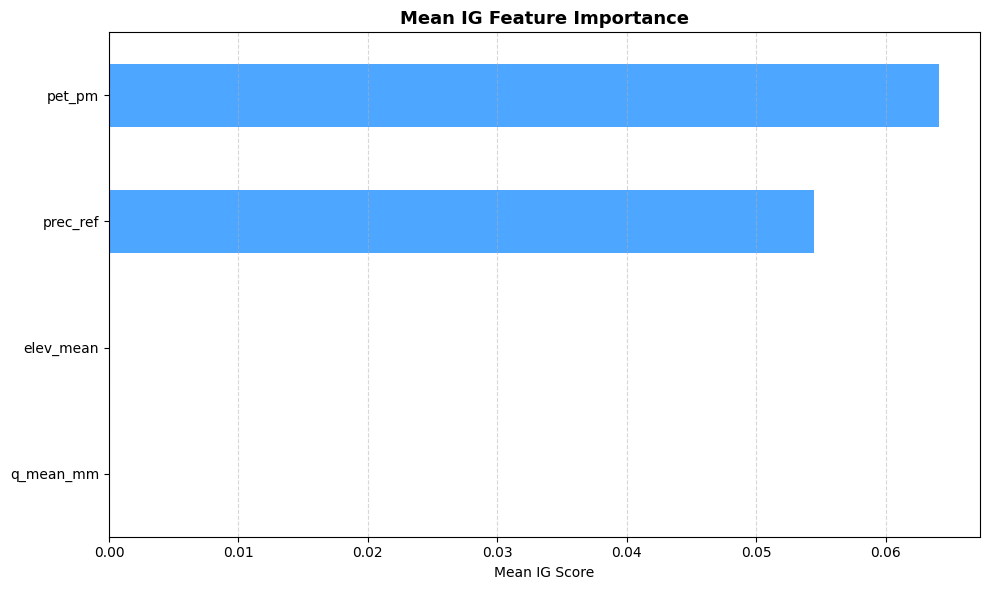

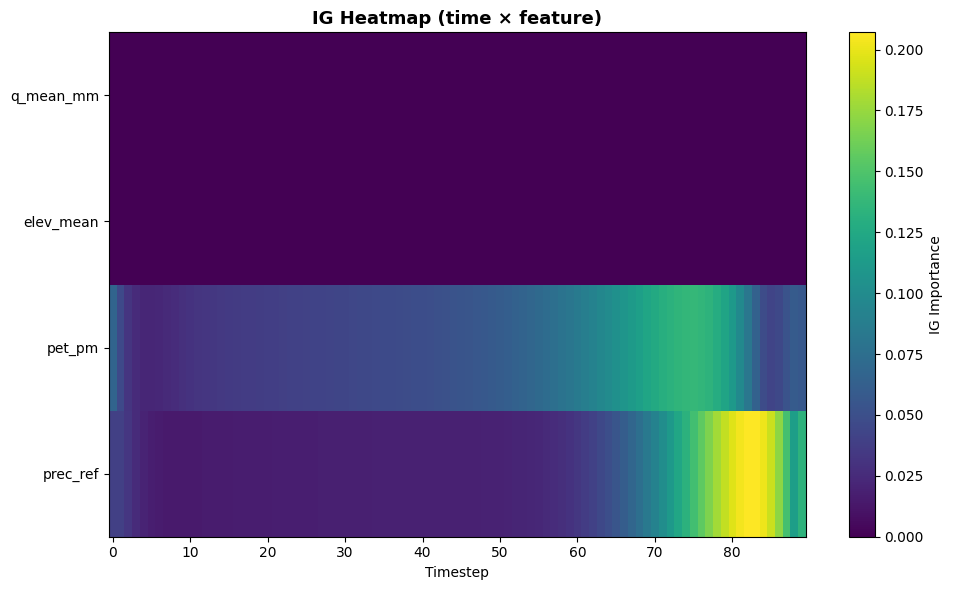

In [17]:
# Integrated Gradients
ig_result_df = compute_integrated_gradients_all(
    model=model,
    X_input=X_ig,
    feature_names=feature_names,
    baseline_type="zero",       
    m_steps=50,
    save_csv_path="./IG_matrix_ID31.csv",  
    plot=True
)